In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

c:\Users\local_user\anaconda3\envs\Fall_25_ML\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.sparse import csr_matrix, issparse


In [2]:
xtrain = pd.read_csv('X_train.csv')
ytrain = pd.read_csv('y_train.csv')
#print(f"X_train:\n{xtrain.describe()}\n\nY_train:\n{ytrain.describe()}")

In [3]:
#print(f"Y_train value counts:\n{ytrain['Prediction'].value_counts()},\nN/A-s in X_train second column:\n{xtrain['ab_000'].isna().sum()}")

In [4]:
max_na = 0
for col in xtrain.columns:
    na_count = xtrain[col].isna().sum()
    if na_count > max_na:
        max_na = na_count
        max_na_col = col
print(f"Column with max N/A-s: {max_na_col} ({max_na} N/A-s)")

Column with max N/A-s: br_000 (49259 N/A-s)


In [5]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import fbeta_score, precision_recall_curve, average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# XGBoost
from xgboost import XGBClassifier

# Bayesian Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Misc
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42


## Load Data

In [6]:
train_path = "X_train.csv"   # <-- adjust paths if needed
y_path     = "y_train.csv"
test_path  = "X_test.csv"

X = pd.read_csv(train_path)
y = pd.read_csv(y_path)
X_test = pd.read_csv(test_path)

print("Shapes:")
print("X:", X.shape)
print("y:", y.shape)
print("X_test:", X_test.shape)

Shapes:
X: (60000, 170)
y: (60000, 2)
X_test: (16000, 170)


## Convert "na" --> np.nan

In [7]:
X = X.replace("na", np.nan)
X_test = X_test.replace("na", np.nan)

# Convert to floats
X = X.astype(float)
X_test = X_test.astype(float)

## Class Imbalance

In [8]:
print(y['Prediction'].value_counts())

neg = y['Prediction'].value_counts()['neg']
pos = y['Prediction'].value_counts()['pos']
scale_pos_weight = neg / pos

print(f"\nscale_pos_weight ≈ {scale_pos_weight:.2f}") # for XGBoost

Prediction
neg    58914
pos     1086
Name: count, dtype: int64

scale_pos_weight ≈ 54.25


## Missing Values

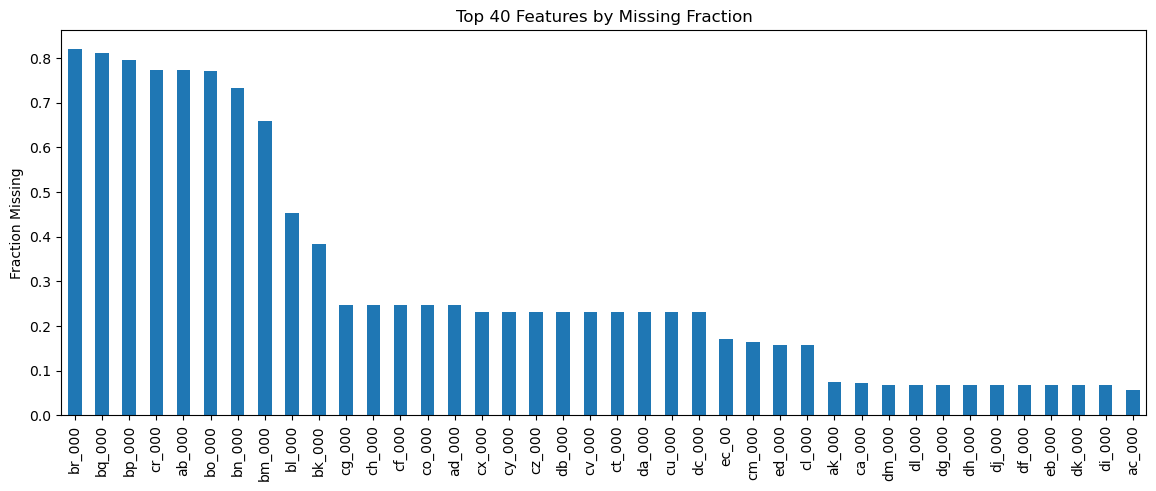

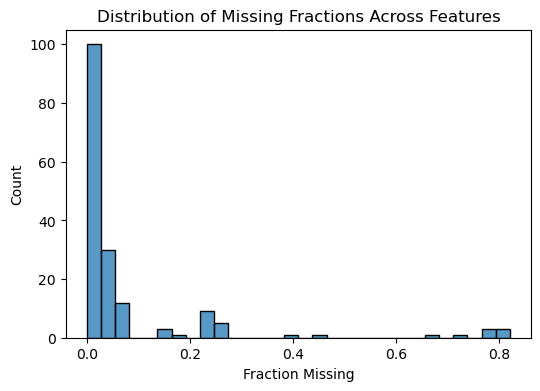

In [9]:
missing_frac = X.isna().mean().sort_values(ascending=False)
missing_frac.head(20)

# Plot missing value fractions
plt.figure(figsize=(14,5))
missing_frac.head(40).plot(kind="bar")
plt.title("Top 40 Features by Missing Fraction")
plt.ylabel("Fraction Missing")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(missing_frac, bins=30)
plt.title("Distribution of Missing Fractions Across Features")
plt.xlabel("Fraction Missing")
plt.ylabel("Count")
plt.show()


## Drop extremely sparse features

In [10]:
# Thresholds for the two pipelines
thr_kbest = 0.30   # only use relatively dense features for KBest
thr_xgb   = 0.95   # keep almost everything for XGBoost-based pipeline

cols_kbest = missing_frac[missing_frac <= thr_kbest].index
cols_xgb   = missing_frac[missing_frac <= thr_xgb].index

print(f"Features for KBest pipeline (<= {thr_kbest*100:.0f}% missing): {len(cols_kbest)}")
print(f"Features for XGB/SFM pipeline (<= {thr_xgb*100:.0f}% missing): {len(cols_xgb)}")


Features for KBest pipeline (<= 30% missing): 160
Features for XGB/SFM pipeline (<= 95% missing): 170


## Single train-validation split, then branch per pipeline

In [11]:
from sklearn.model_selection import train_test_split

y['Prediction'] = y['Prediction'].map({'neg': 0, 'pos': 1})

# Single split so both pipelines see exactly the same instances
X_train_all, X_val_all, y_train, y_val = train_test_split(
    X, y['Prediction'],
    test_size=0.20,
    stratify=y['Prediction'],
    random_state=RANDOM_STATE
)

print("Overall Train:", X_train_all.shape)
print("Overall Val:  ", X_val_all.shape)

# Now create pipeline-specific views
Xk_train = X_train_all[cols_kbest].copy()
Xk_val   = X_val_all[cols_kbest].copy()

Xx_train = X_train_all[cols_xgb].copy()
Xx_val   = X_val_all[cols_xgb].copy()

# Also prepare test matrices for later
Xk_test = X_test[cols_kbest].copy()
Xx_test = X_test[cols_xgb].copy()

print("KBest Train shape:", Xk_train.shape)
print("SFM/XGB Train shape:", Xx_train.shape)


Overall Train: (48000, 170)
Overall Val:   (12000, 170)
KBest Train shape: (48000, 160)
SFM/XGB Train shape: (48000, 170)


## Pipelines

- I will train two pipelines to begin with. Both will use XGBoost, but with different feature selection approaches:
    - Pipeline A will use sklearn's SelectKBest() method
    - Pipeline B will use sklearn's SelectFromModel() method, with XGBoost as the model

### Pipeline A - SelectKBest()

In [12]:
# -------- Pipeline A: SelectKBest + XGBoost --------
pipe_kbest = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # handle NaNs
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=40)),  # k tuned
    ("clf", XGBClassifier(
        tree_method="hist",
        #predictor="gpu_predictor",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight
    )),
])

search_kbest = {
    "select__k": Integer(20, min(120, len(cols_kbest))),  # sanity upper bound
    "clf__max_depth": Integer(3, 10),
    "clf__learning_rate": Real(0.01, 0.3, prior="log-uniform"),
    "clf__subsample": Real(0.5, 1.0),
    "clf__colsample_bytree": Real(0.5, 1.0),
    "clf__min_child_weight": Integer(1, 10),
    "clf__gamma": Real(0.0, 5.0),
}

opt_kbest = BayesSearchCV(
    estimator=pipe_kbest,
    search_spaces=search_kbest,
    n_iter=40,              # adjust if needed
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting KBest + XGBoost pipeline...")
opt_kbest.fit(Xk_train, y_train)
print("Best KBest params:", opt_kbest.best_params_)


Fitting KBest + XGBoost pipeline...
Best KBest params: OrderedDict({'clf__colsample_bytree': 0.5, 'clf__gamma': 0.0, 'clf__learning_rate': 0.07783776501437721, 'clf__max_depth': 3, 'clf__min_child_weight': 10, 'clf__subsample': 1.0, 'select__k': 120})


In [13]:
pred_kb  = opt_kbest.best_estimator_.predict(Xk_val)
ba_kb  = balanced_accuracy_score(y_val, pred_kb)
print("Balanced Accuracy (KBest pipeline):       ", ba_kb)
print("\n=== KBest Classification Report ===")
print(classification_report(y_val, pred_kb))

Balanced Accuracy (KBest pipeline):        0.9464146386010307

=== KBest Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     11783
           1       0.34      0.93      0.50       217

    accuracy                           0.97     12000
   macro avg       0.67      0.95      0.74     12000
weighted avg       0.99      0.97      0.97     12000



### Pipeline B - SelectFromModel()

In [24]:
# -------- Pipeline B: SelectFromModel(XGB) + XGBoost --------

# XGB model for feature selection
xgb_fs = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

pipe_sfm = Pipeline([
    # no imputer, no scaler — let XGB see the raw NaN pattern
    ("select", SelectFromModel(estimator=xgb_fs, threshold="median")),
    ("clf", XGBClassifier(
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight
    )),
])

search_sfm = {
    "clf__max_depth": Integer(3, 10),
    "clf__learning_rate": Real(0.01, 0.3, prior="log-uniform"),
    "clf__subsample": Real(0.5, 1.0),
    "clf__colsample_bytree": Real(0.5, 1.0),
    "clf__min_child_weight": Integer(1, 10),
    "clf__gamma": Real(0.0, 5.0),
}

opt_sfm = BayesSearchCV(
    estimator=pipe_sfm,
    search_spaces=search_sfm,
    n_iter=40,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting SelectFromModel + XGBoost pipeline...")
opt_sfm.fit(Xx_train, y_train)
print("Best SFM params:", opt_sfm.best_params_)


Fitting SelectFromModel + XGBoost pipeline...
Best SFM params: OrderedDict({'clf__colsample_bytree': 1.0, 'clf__gamma': 5.0, 'clf__learning_rate': 0.0709785300956319, 'clf__max_depth': 3, 'clf__min_child_weight': 10, 'clf__subsample': 0.9812295513900081})


## Check which model was better

In [25]:
# --- Predictions on hold-out validation ---
pred_kb  = opt_kbest.best_estimator_.predict(Xk_val)
pred_sfm = opt_sfm.best_estimator_.predict(Xx_val)

ba_kb  = balanced_accuracy_score(y_val, pred_kb)
ba_sfm = balanced_accuracy_score(y_val, pred_sfm)

print("Balanced Accuracy (KBest pipeline):       ", ba_kb)
print("Balanced Accuracy (SelectFromModel pipeline):", ba_sfm)

print("\n=== KBest Classification Report ===")
print(classification_report(y_val, pred_kb))

print("\n=== SelectFromModel Classification Report ===")
print(classification_report(y_val, pred_sfm))


Balanced Accuracy (KBest pipeline):        0.9464146386010307
Balanced Accuracy (SelectFromModel pipeline): 0.9514472736829713

=== KBest Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     11783
           1       0.34      0.93      0.50       217

    accuracy                           0.97     12000
   macro avg       0.67      0.95      0.74     12000
weighted avg       0.99      0.97      0.97     12000


=== SelectFromModel Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     11783
           1       0.35      0.94      0.50       217

    accuracy                           0.97     12000
   macro avg       0.67      0.95      0.74     12000
weighted avg       0.99      0.97      0.97     12000



In [26]:
def extended_classification_report(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn)   # recall for class 1
    specificity = tn / (tn + fp)

    print(classification_report(y_true, y_pred))
    print(f"Specificity: {specificity:.4f}")
    print(f"Sensitivity (Recall for class 1): {sensitivity:.4f}")

print("=== KBest Extended Report ===")
extended_classification_report(y_val, pred_kb)

print("\n=== SFM Extended Report ===")
extended_classification_report(y_val, pred_sfm)


=== KBest Extended Report ===
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     11783
           1       0.34      0.93      0.50       217

    accuracy                           0.97     12000
   macro avg       0.67      0.95      0.74     12000
weighted avg       0.99      0.97      0.97     12000

Specificity: 0.9666
Sensitivity (Recall for class 1): 0.9263

=== SFM Extended Report ===
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     11783
           1       0.35      0.94      0.50       217

    accuracy                           0.97     12000
   macro avg       0.67      0.95      0.74     12000
weighted avg       0.99      0.97      0.97     12000

Specificity: 0.9674
Sensitivity (Recall for class 1): 0.9355


## Choose best pipeline and train on full train + valid data

In [16]:
# Full design matrices for final training
X_kbest_full = X[cols_kbest].copy()
X_xgb_full   = X[cols_xgb].copy()

# Choose model
if ba_sfm > ba_kb:
    print("\nUsing SelectFromModel pipeline for final training.")
    final_pipe = opt_sfm.best_estimator_
    X_train_final = X_xgb_full
    X_test_final  = Xx_test
else:
    print("\nUsing KBest pipeline for final training.")
    final_pipe = opt_kbest.best_estimator_
    X_train_final = X_kbest_full
    X_test_final  = Xk_test

# Fit on all available labelled data
final_pipe.fit(X_train_final, y['Prediction'])



Using KBest pipeline for final training.


,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [17]:
print(final_pipe.named_steps['clf'])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=5.0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07033543604307806,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)


In [18]:
print("Final model:", final_pipe)
print("Number of features used:", final_pipe.named_steps['select'].k)
preds = final_pipe.predict(X_train_final)
print("Balanced accuracy on full training:", balanced_accuracy_score(y['Prediction'], preds))


Final model: Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('select', SelectKBest(k=120)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=...
                               gamma=5.0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.07033543604307806, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
              

In [18]:
y_test_pred = final_pipe.predict(X_test_final)

# Convert predictions to original labels if needed
y_test_pred = np.where(y_test_pred == 1, 'pos', 'neg')

submission = pd.DataFrame({
    "Id": np.arange(len(y_test_pred)),
    "Prediction": y_test_pred
})

submission.to_csv("my_submission.csv", index=False)
print("Saved my_submission.csv")


Saved my_submission.csv


## Training Some Simpler Models
- Logit()
- SVM
- DecisionTreeClassifier

In [19]:
# KBest selector from the best XGBoost pipeline
kbest_selector = opt_kbest.best_estimator_.named_steps["select"]
support_mask   = kbest_selector.get_support()   # boolean array of length len(cols_kbest)

selected_cols = cols_kbest[support_mask]

print("Number of selected features:", len(selected_cols))  # should be 120

# Build train/val/full matrices for classical models
X_sel_train = X_train_all[selected_cols].copy()
X_sel_val   = X_val_all[selected_cols].copy()
X_sel_full  = X[selected_cols].copy()
X_sel_test  = X_test[selected_cols].copy()


Number of selected features: 120


### Logit() Pipeline

In [20]:
pipe_logit = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2",
        class_weight="balanced",
        max_iter=500,
        solver="lbfgs",
        n_jobs=-1,
        random_state=RANDOM_STATE
    )),
])

search_logit = {
    "clf__C": Real(1e-3, 1e2, prior="log-uniform"),
}

opt_logit = BayesSearchCV(
    estimator=pipe_logit,
    search_spaces=search_logit,
    n_iter=20,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting Logistic Regression pipeline...")
opt_logit.fit(X_sel_train, y_train)

print("Best Logit params:", opt_logit.best_params_)

pred_logit = opt_logit.best_estimator_.predict(X_sel_val)
ba_logit   = balanced_accuracy_score(y_val, pred_logit)

print("Balanced Accuracy (Logit):", ba_logit)
print("\n=== Logistic Regression Classification Report ===")
print(classification_report(y_val, pred_logit))


Fitting Logistic Regression pipeline...
Best Logit params: OrderedDict({'clf__C': 0.008036703744578471})
Balanced Accuracy (Logit): 0.9265854384450612

=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11783
           1       0.42      0.88      0.57       217

    accuracy                           0.98     12000
   macro avg       0.71      0.93      0.78     12000
weighted avg       0.99      0.98      0.98     12000



### Linear SVM Pipeline

In [22]:
pipe_svm = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LinearSVC(
        class_weight="balanced",
        random_state=RANDOM_STATE
    )),
])

search_svm = {
    "clf__C": Real(1e-3, 1e1, prior="log-uniform"),
}

opt_svm = BayesSearchCV(
    estimator=pipe_svm,
    search_spaces=search_svm,
    n_iter=15,
    cv=4,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting Linear SVM pipeline...")
opt_svm.fit(X_sel_train, y_train)

print("Best SVM params:", opt_svm.best_params_)

pred_svm = opt_svm.best_estimator_.predict(X_sel_val)
ba_svm   = balanced_accuracy_score(y_val, pred_svm)

print("Balanced Accuracy (Linear SVM):", ba_svm)
print("\n=== Linear SVM Classification Report ===")
print(classification_report(y_val, pred_svm))


Fitting Linear SVM pipeline...
Best SVM params: OrderedDict({'clf__C': 0.0010340016434251915})
Balanced Accuracy (Linear SVM): 0.9131000257732866

=== Linear SVM Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11783
           1       0.42      0.85      0.56       217

    accuracy                           0.98     12000
   macro avg       0.71      0.91      0.77     12000
weighted avg       0.99      0.98      0.98     12000



### DecisionTreeClassifier ~ C4.5 Pipeline

In [23]:
pipe_dt = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", DecisionTreeClassifier(
        class_weight="balanced",
        random_state=RANDOM_STATE
    )),
])

search_dt = {
    "clf__max_depth": Integer(2, 12),
    "clf__min_samples_leaf": Integer(1, 50),
    "clf__min_samples_split": Integer(2, 50),
}

opt_dt = BayesSearchCV(
    estimator=pipe_dt,
    search_spaces=search_dt,
    n_iter=30,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Fitting Decision Tree pipeline...")
opt_dt.fit(X_sel_train, y_train)

print("Best DT params:", opt_dt.best_params_)

pred_dt = opt_dt.best_estimator_.predict(X_sel_val)
ba_dt   = balanced_accuracy_score(y_val, pred_dt)

print("Balanced Accuracy (Decision Tree):", ba_dt)
print("\n=== Decision Tree Classification Report ===")
print(classification_report(y_val, pred_dt))


Fitting Decision Tree pipeline...
Best DT params: OrderedDict({'clf__max_depth': 4, 'clf__min_samples_leaf': 22, 'clf__min_samples_split': 2})
Balanced Accuracy (Decision Tree): 0.9344949824221492

=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     11783
           1       0.28      0.91      0.43       217

    accuracy                           0.96     12000
   macro avg       0.64      0.93      0.70     12000
weighted avg       0.99      0.96      0.97     12000



## Analysis of Different Models

In [24]:
# Include here in the table other statistics as well, such as TPR, FPR, success rate, error rate, recall/sensitivity, specificity, precision, etc.
results = pd.DataFrame({
    "Model": [
        "XGBoost + KBest",
        "XGBoost + SFM",
        "Logistic Regression",
        "Linear SVM",
        "Decision Tree"
    ],
    "Balanced Accuracy": [
        ba_kb,
        ba_sfm,
        ba_logit,
        ba_svm,
        ba_dt
    ]
})

print(results)


                 Model  Balanced Accuracy
0      XGBoost + KBest           0.950980
1        XGBoost + SFM           0.946232
2  Logistic Regression           0.926585
3           Linear SVM           0.913100
4        Decision Tree           0.934495


## Saving Models and Data for Reproducibility

In [39]:
# Get prefix for saved files
import datetime
date = datetime.datetime.now()
date_prefix = f"{date.year}{date.month}{date.day}"
print("Date prefix for saved files:", date_prefix)

Date prefix for saved files: 2025128


### Models

In [ ]:
import joblib

# Save the best estimators found by BayesSearchCV
joblib.dump(opt_kbest.best_estimator_, f"model_kbest_pipeline{opt_kbest.best_estimator_.named_steps['select'].k}_{date_prefix}.pkl")
joblib.dump(opt_sfm.best_estimator_, f"model_sfm_pipeline_{date_prefix}.pkl")

print(f"Saved: model_kbest_pipeline{opt_kbest.best_estimator_.named_steps['select'].k}_{date_prefix}.pkl")
print(f"Saved: model_sfm_pipeline_{date_prefix}.pkl")


Saved: model_kbest_pipeline160_2025128.pkl


### Hyperparameters

In [ ]:
import json

params_to_save = {
    "kbest_best_params": opt_kbest.best_params_,
    "sfm_best_params": opt_sfm.best_params_,
    "scale_pos_weight": scale_pos_weight,
    "num_features_kbest": int(opt_kbest.best_estimator_.named_steps["select"].k),
    "um_features_sfm": int(len(cols_xgb)),   # SFM keeps features above median only at fit time
    "cols_kbest": list(cols_kbest),
    "ols_xgb": list(cols_xgb)
}

with open(f"model_metadata_{date_prefix}.json", "w") as f:
    json.dump(params_to_save, f, indent=4)

print(f"model_metadata_{date_prefix}.json")


model_metadata_2025128.json


### Final Model

In [ ]:
joblib.dump(final_pipe, f"final_model_{date_prefix}.pkl")
print(f"Saved: final_model_{date_prefix}.pkl")

### BayesSearchCV() Results

In [ ]:
df_kbest_cv = pd.DataFrame(opt_kbest.cv_results_)
f_sfm_cv   = pd.DataFrame(opt_sfm.cv_results_)

df_kbest_cv.to_csv(f"kbest_cv_results{opt_kbest.best_estimator_.named_steps['select'].k}_{date_prefix}.csv", index=False)
f_sfm_cv.to_csv(f"sfm_cv_results_{date_prefix}.csv", index=False)

print(f"Saved: kbest_cv_results_{date_prefix}.csv, sfm_cv_results_{date_prefix}.csv")


Saved: kbest_cv_results_2025128.csv, sfm_cv_results_2025128.csv


## Load like this

In [14]:
import joblib

kbest_model = joblib.load("model_kbest_pipeline120_2025127.pkl")
sfm_model   = joblib.load("model_sfm_pipeline_2025127.pkl")
final_model = joblib.load("final_model_2025127.pkl")

In [15]:
# --- Predictions on hold-out validation ---
pred_final  = kbest_model.predict(Xk_val)
pred_sfm = sfm_model.predict(Xx_val)
pred_final_model = final_model.predict(X_train_final)

ba_kb  = balanced_accuracy_score(y_val, pred_kb)
ba_sfm = balanced_accuracy_score(y_val, pred_sfm)
ba_final = balanced_accuracy_score(y['Prediction'], pred_final_model)

print("Balanced Accuracy (KBest pipeline):       ", ba_kb)
print("Balanced Accuracy (SelectFromModel pipeline):", ba_sfm)
print("Balanced Accuracy (Final loaded model):      ", ba_final)

print("\n=== KBest Classification Report ===")
print(classification_report(y_val, pred_kb))

print("\n=== SelectFromModel Classification Report ===")
print(classification_report(y_val, pred_sfm))

print("\n=== Final Model Classification Report ===")
print(classification_report(y['Prediction'], pred_final_model))


NameError: name 'X_train_final' is not defined

# Visualizations

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, balanced_accuracy_score
from xgboost import XGBClassifier

## Exploratory Data Analysis (EDA)

### Bar chart and histogram to show *missing values*

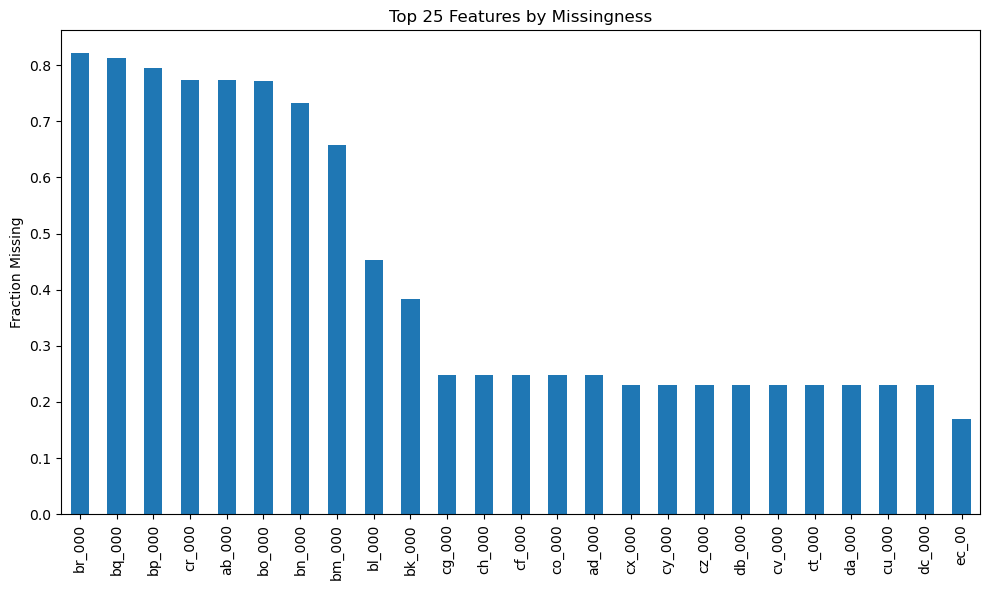

In [18]:
# Bar Chart of Missing Fractions
missing_frac = X.isna().mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
missing_frac.head(25).plot(kind='bar')
plt.ylabel("Fraction Missing")
plt.title("Top 25 Features by Missingness")
plt.tight_layout()
plt.show()


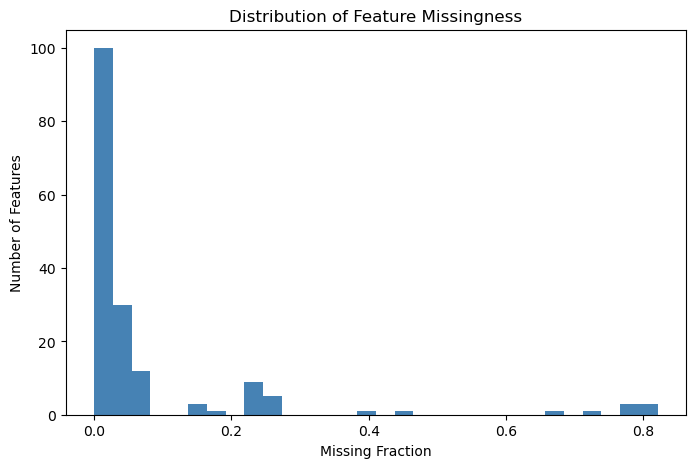

In [19]:
# Histogram of Missing Fractions
plt.figure(figsize=(8,5))
plt.hist(missing_frac, bins=30, color='steelblue')
plt.xlabel("Missing Fraction")
plt.ylabel("Number of Features")
plt.title("Distribution of Feature Missingness")
plt.show()

### Class Imbalance

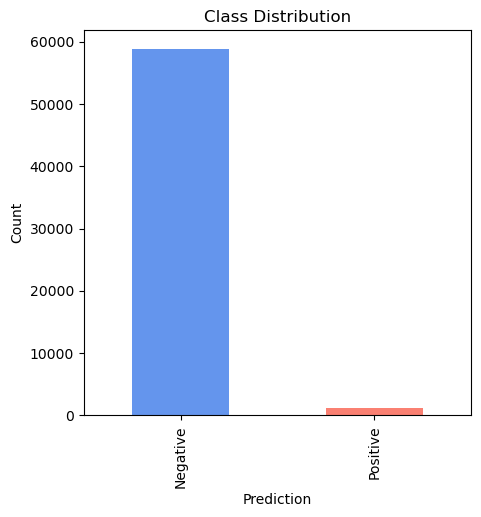

In [20]:
plt.figure(figsize=(5,5))
y['Prediction'].value_counts().plot(kind='bar', color=['cornflowerblue','salmon'])
plt.xticks([0,1], ['Negative','Positive'])
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()

## Data Preparation

### Feature Density Before vs After Filtering

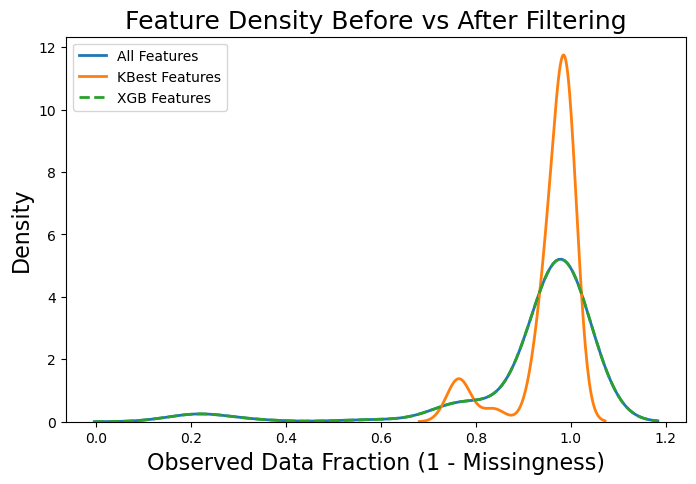

In [14]:
plt.figure(figsize=(8,5))
sns.kdeplot(1 - missing_frac, label="All Features", linewidth=2)
sns.kdeplot(1 - missing_frac[cols_kbest], label="KBest Features", linewidth=2)
sns.kdeplot(1 - missing_frac[cols_xgb], label="XGB Features", linewidth=2, linestyle='--')
plt.xlabel("Observed Data Fraction (1 - Missingness)", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.title("Feature Density Before vs After Filtering", fontsize=18)
plt.legend()
plt.show()

### Table of Retained Counts

In [22]:
pd.DataFrame({
    "Stage": ["Original", "KBest Preprocessing", "XGB Preprocessing"],
    "Num Features": [X.shape[1], len(cols_kbest), len(cols_xgb)]
})


,Stage,Num Features
0,Original,170
1,KBest Preprocessing,160
2,XGB Preprocessing,170


## Hyperparamter Tuning

### BayesSearchCV convergence (best score vs iteration)

In [23]:
df_kbest_cv = pd.read_csv("kbest_cv_results_2025127.csv")
df_sfm_cv   = pd.read_csv("sfm_cv_results_2025127.csv")

In [24]:
df_kbest_cv.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__colsample_bytree,param_clf__gamma,param_clf__learning_rate,param_clf__max_depth,param_clf__min_child_weight,param_clf__subsample,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.920691,0.012270,0.042515,0.001199,0.705052,3.638629,0.238759,5,7,0.707059,55,OrderedDict({'clf__colsample_bytree': 0.705051...,0.918412,0.915721,0.920726,0.945845,0.918064,0.923753,0.011159,38
1,2.056727,0.011241,0.041697,0.001421,0.918694,4.416576,0.028066,10,9,0.531156,34,OrderedDict({'clf__colsample_bytree': 0.918694...,0.927506,0.954325,0.922344,0.953158,0.938144,0.939095,0.013004,32
2,1.838431,0.021200,0.036407,0.000704,0.722416,4.593613,0.014285,6,3,0.726833,36,OrderedDict({'clf__colsample_bytree': 0.722416...,0.940630,0.953600,0.948543,0.955837,0.942787,0.948279,0.005903,25
3,3.696898,0.024518,0.054190,0.001390,0.906198,0.859358,0.076452,9,6,0.547728,96,OrderedDict({'clf__colsample_bytree': 0.906197...,0.917775,0.938603,0.928763,0.949673,0.915031,0.929969,0.012931,35
4,2.685244,0.031865,0.044860,0.002347,0.899777,2.190146,0.059963,8,9,0.858516,62,OrderedDict({'clf__colsample_bytree': 0.899776...,0.933790,0.934192,0.931000,0.961177,0.937383,0.939508,0.011022,30


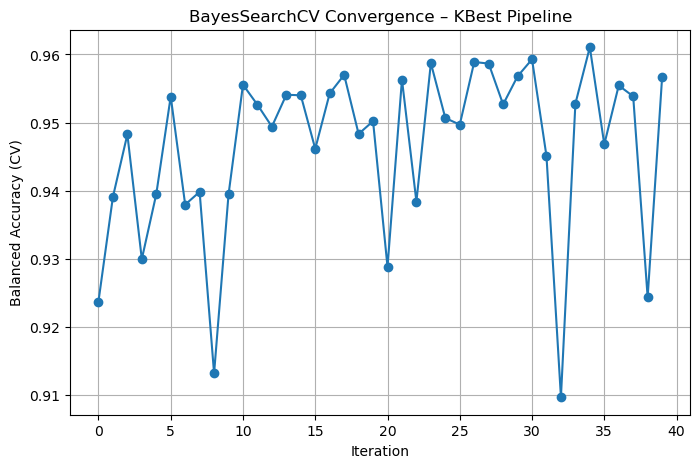

In [25]:
plt.figure(figsize=(8,5))
plt.plot(df_kbest_cv["mean_test_score"], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Balanced Accuracy (CV)")
plt.title("BayesSearchCV Convergence – KBest Pipeline")
plt.grid(True)
plt.show()


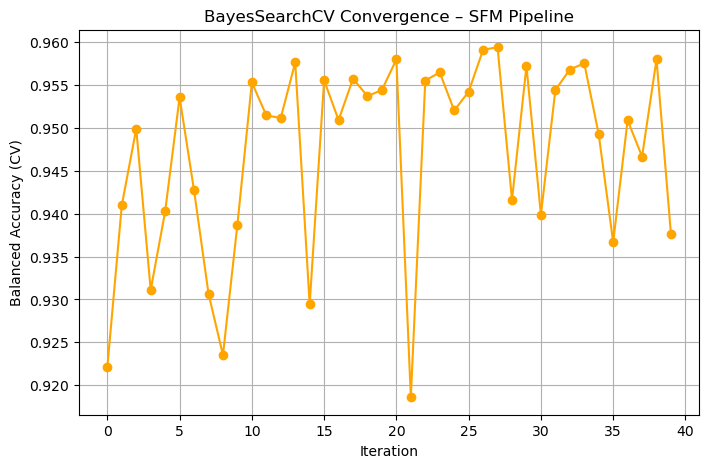

In [26]:
plt.figure(figsize=(8,5))
plt.plot(df_sfm_cv["mean_test_score"], marker='o', color='orange')
plt.xlabel("Iteration")
plt.ylabel("Balanced Accuracy (CV)")
plt.title("BayesSearchCV Convergence – SFM Pipeline")
plt.grid(True)
plt.show()


In [28]:
pd.DataFrame(opt_kbest.best_params_.items(), columns=["Parameter", "Value"])
pd.DataFrame(opt_sfm.best_params_.items(), columns=["Parameter", "Value"])

,Parameter,Value
0,clf__colsample_bytree,0.500000
1,clf__gamma,3.934255
2,clf__learning_rate,0.050833
3,clf__max_depth,4.000000
4,clf__min_child_weight,10.000000
5,clf__subsample,1.000000


## Model Evaluation Visualizations

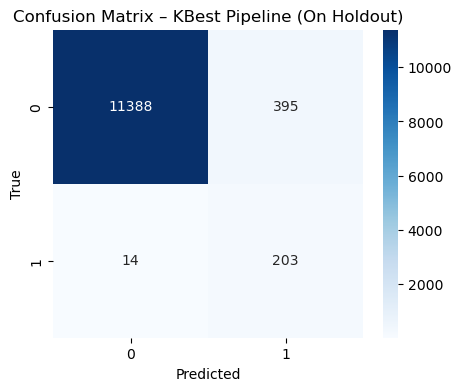

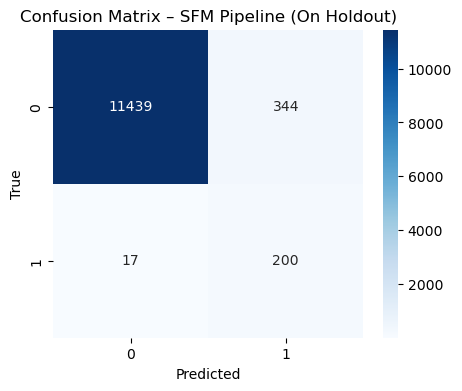

In [30]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_conf_matrix(y_val, pred_kb, "Confusion Matrix – KBest Pipeline (On Holdout)")
plot_conf_matrix(y_val, pred_sfm, "Confusion Matrix – SFM Pipeline (On Holdout)")


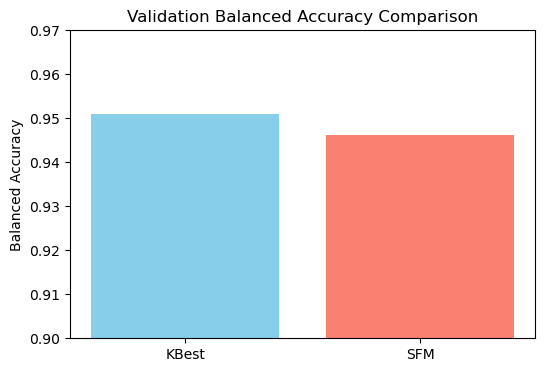

In [31]:
plt.figure(figsize=(6,4))
plt.bar(["KBest", "SFM"], [ba_kb, ba_sfm], color=['skyblue','salmon'])
plt.ylabel("Balanced Accuracy")
plt.title("Validation Balanced Accuracy Comparison")
plt.ylim(0.90, 0.97)
plt.show()


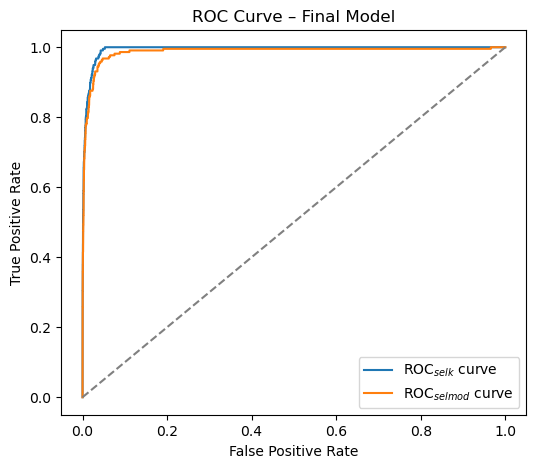

In [36]:
y_score_kbest = kbest_model.predict_proba(Xk_val)[:,1]
fpr_kbest, tpr_kbest, _ = roc_curve(y_val, y_score_kbest)
y_score_sfm = sfm_model.predict_proba(Xx_val)[:,1]
fpr_sfm, tpr_sfm, _ = roc_curve(y_val, y_score_sfm)

plt.figure(figsize=(6,5))
plt.plot(fpr_kbest, tpr_kbest, label=r"ROC$_{selk}$ curve")
plt.plot(fpr_sfm, tpr_sfm, label=r"ROC$_{selmod}$ curve")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Final Model")
plt.legend()
plt.show()


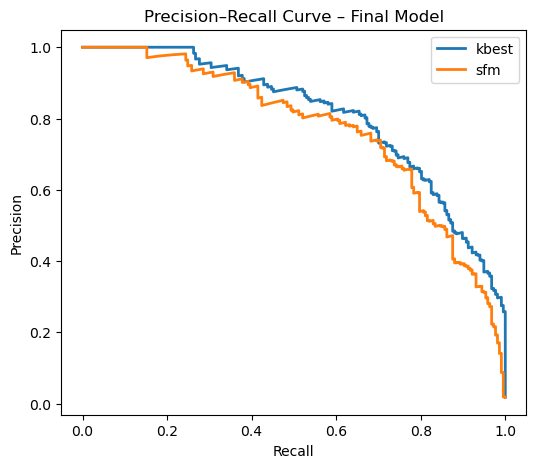

In [41]:
precision_kbest, recall_kbest, _ = precision_recall_curve(y_val, y_score_kbest)
precision_sfm, recall_sfm, _ = precision_recall_curve(y_val, y_score_sfm)

plt.figure(figsize=(6,5))
plt.plot(recall_kbest, precision_kbest, linewidth=2, label="kbest")
plt.plot(recall_sfm, precision_sfm, linewidth=2, label="sfm")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Final Model")
plt.legend()
plt.show()


## Feature Importance

Features seen by XGB: 120
Length of importances: 120


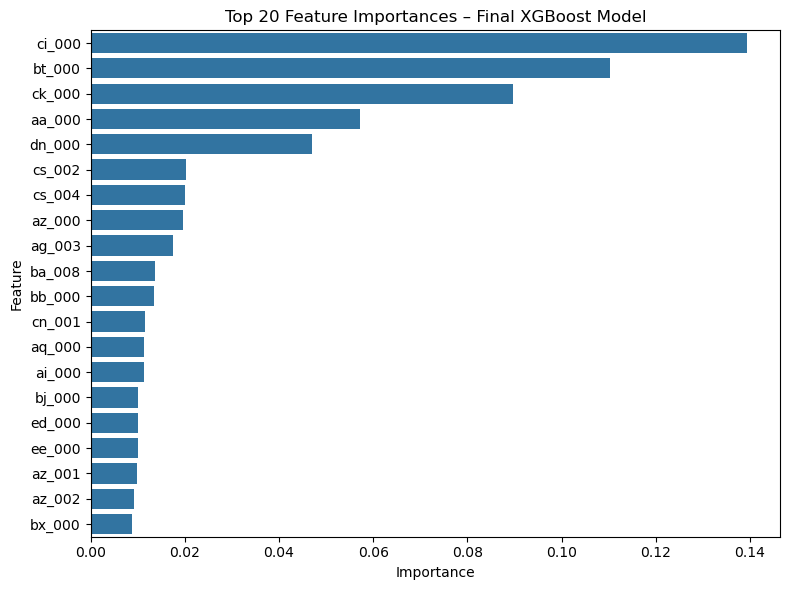

In [47]:
# Extract the final classifier and selector from the pipeline
final_xgb = final_pipe.named_steps["clf"]
selector  = final_pipe.named_steps["select"]

# Mask of features that were kept by SelectKBest
support_mask = selector.get_support()  # boolean mask of shape (n_features_before_selection,)

# Column names corresponding to selected features
selected_feature_names = X_train_final.columns[support_mask]

# Sanity check: lengths must match now
print("Features seen by XGB:", len(selected_feature_names))
print("Length of importances:", len(final_xgb.feature_importances_))

# Build importance DataFrame
imp_df = pd.DataFrame({
    "feature": selected_feature_names,
    "importance": final_xgb.feature_importances_
}).sort_values("importance", ascending=False)

# Plot top 20
plt.figure(figsize=(8,6))
sns.barplot(data=imp_df.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importances – Final XGBoost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [50]:
imp_df.head(10)

,feature,importance
116,ci_000,0.139433
118,bt_000,0.110379
115,ck_000,0.089688
119,aa_000,0.057106
37,dn_000,0.047063
99,cs_002,0.020148
97,cs_004,0.019984
77,az_000,0.019547
89,ag_003,0.017419
51,ba_008,0.013623


## Probability Distribution

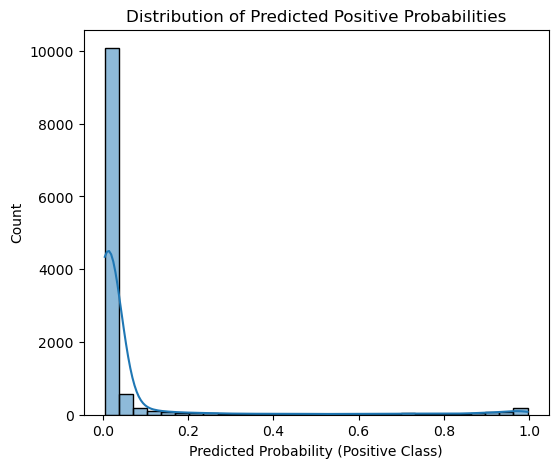

In [ ]:
plt.figure(figsize=(6,5))
sns.histplot(kbest_model.predict_proba(Xk_val)[:,1], bins=30, kde=True)
plt.title("Distribution of Predicted Positive Probabilities")
plt.xlabel("Predicted Probability (Positive Class)")
plt.ylabel("Count")
plt.show()

# mostly near 0/1 → confident
# mostly in the middle → uncertain

## Calibration Curve

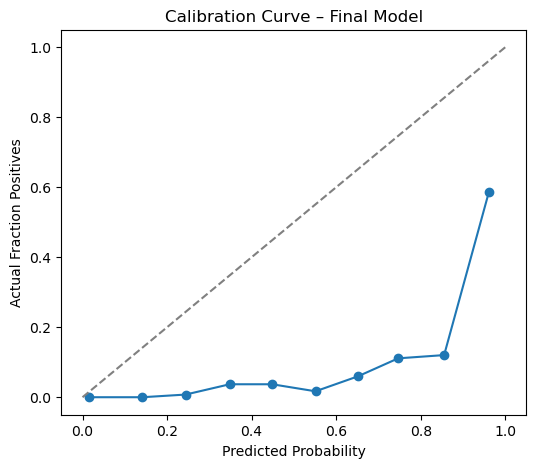

In [54]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_val, y_score, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Fraction Positives")
plt.title("Calibration Curve – Final Model")
plt.show()


In [56]:
from graphviz import Digraph

dot = Digraph(comment="Final ML Pipeline")
dot.attr(rankdir='LR', size='10,5')

dot.node("A", "Raw Input Features\n(170 variables)")
dot.node("B", "Missingness Filter\n(≤ 30% NaN)")
dot.node("C", "SimpleImputer\n(median)")
dot.node("D", "StandardScaler")
dot.node("E", "SelectKBest\n(ANOVA, k=120)")
dot.node("F", "XGBoost Classifier\n(depth=3, LR≈0.07)")
dot.node("G", "Predictions")

dot.edges(["AB", "BC", "CD", "DE", "EF", "FG"])

dot.render("pipeline_diagram", format="pdf")


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH